In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from scipy.optimize import minimize
import math
from scipy import optimize
from scipy.stats import norm, expon
from scipy import special
import numpy as np
import scipy.stats as si
import sympy as sy
from sympy.stats import Normal, cdf

In [2]:
pg = pd.read_csv('pg.csv')
wmt = pd.read_csv('wmt.csv')
pg['stock'] = 'pg'
wmt['stock']='wmt'
portfolio = pd.DataFrame(       pg['Dates'])
portfolio['PX_LAST'] = 108*wmt['PX_LAST']+97*pg['PX_LAST']
portfolio['Dates'] = pd.to_datetime(portfolio['Dates'] )

In [14]:
def Log_Return(data):
    log_return = []
    log_return_sq = []
    for i in range(0,len(data)):
        if i+1 <= len(data)-1:
            log_return.append(np.log(data['PX_LAST'][i]/data['PX_LAST'][i+1]))  
            log_return_sq.append(np.log(data['PX_LAST'][i]/data['PX_LAST'][i+1])**2)
        else:
            log_return.append(0)
            log_return_sq.append(0**2)
    
    data['log_return'] = log_return
    data['log_return_sq'] = log_return_sq
    return data

def calculate_ma_sd(data,l):

    ma = []
    var = []
    sd = []
    for i in range(0,len(data['log_return'])):
        if i < len(data):
            ma.append(np.mean(data['log_return'][i:i+int(252*l)]))
            var.append( np.mean(data['log_return_sq'][i:i+int(252*l)]) - np.mean(data['log_return'][i:i+int(252*l)])**2)
    for v in var: 
        sd.append(v**0.5)
    
    data['ma'] = ma
    data['sd'] = sd
    data['var'] = var
    return data

def sigma_mu(data):
    sigma = []
    mu = []
    short_VaR = []
    long_VaR = []
    ES = []
    v0 = 10000
    for i in range(0,len(data)):
        sigma.append(data['sd'][i]*(252**0.5))
    for i in range(0,len(data)):
        mu.append(data['ma'][i]*252 + (sigma[i]**2)/2)
    for i in range(0, len(data)):
        
        
        shares = 10000/data['PX_LAST'][i]
        position_0 = 10000
        stock_value_0 = shares*data['PX_LAST'][i]
        stock_value_t = shares*data['PX_LAST'][i]*np.exp(sigma[i]* ((5/252)**0.5) * norm.ppf(0.99) + (mu[i] - sigma[i]**2/2)*(5/252))
        position_t = position_0 + stock_value_0 - stock_value_t
        short_VaR.append(position_0 - position_t )
        long_VaR.append( 10000 - shares*data['PX_LAST'][i]*np.exp(sigma[i]* ((5/252)**0.5) * norm.ppf(1-0.99) + (mu[i] - sigma[i]**2/2)*(5/252))  )
        es_1 = norm.cdf(norm.ppf(1-0.975) - (5/252)**0.5*sigma[i])
        es_2 = shares*data['PX_LAST'][i] * np.exp(mu[i] *(5/252))/(1-0.975)
        ES.append(10000 - es_2*es_1)
        
    data['sigma'] = sigma
    data['mu'] = mu
    data['short_VaR'] = short_VaR
    data['long_VaR'] = long_VaR
    data['short_ES'] = ES
    return sigma, mu, short_VaR, ES, long_VaR

def all_in_one(data, l):
    data1 = Log_Return(data)
    data2 = calculate_ma_sd(data1,l)
    return sigma_mu(data2)

Text(0.5, 1.0, 'PG VaR Short vs Long')

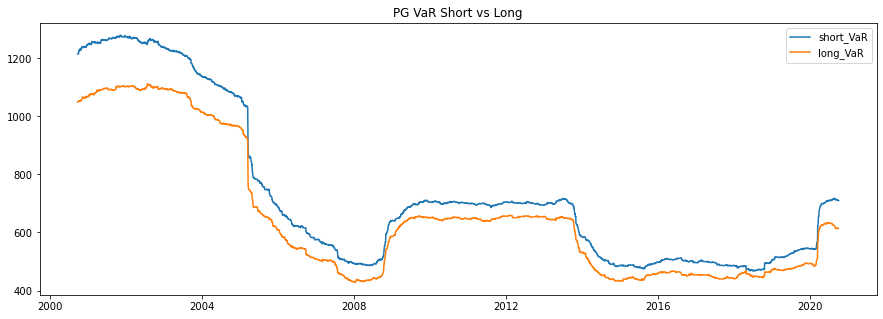

In [4]:
#pg
date = pd.to_datetime(pg['Dates'][0:252*20])
plt.figure(figsize = (15,5))
plt.plot(date[::-1],all_in_one(pg, 5)[2][0:252*20][::-1], label = 'short_VaR')
plt.plot(date[::-1],all_in_one(pg, 5)[4][0:252*20][::-1], label = 'long_VaR')
plt.legend()
plt.title('PG VaR Short vs Long')

Text(0.5, 1.0, 'wmt VaR Short vs Long')

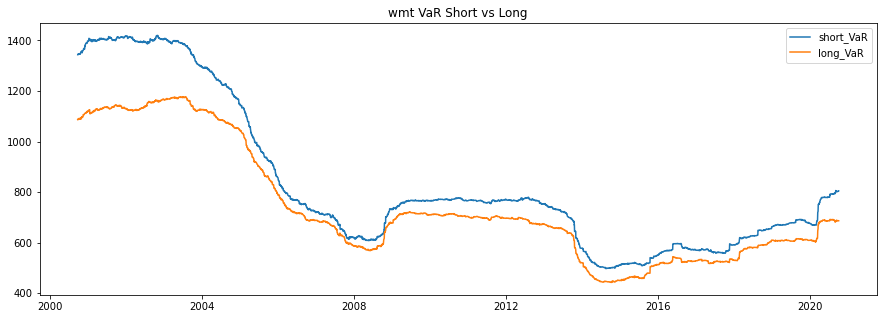

In [5]:
#pg
date = pd.to_datetime(pg['Dates'][0:252*20])
plt.figure(figsize = (15,5))
plt.plot(date[::-1],all_in_one(wmt, 5)[2][0:252*20][::-1], label = 'short_VaR')
plt.plot(date[::-1],all_in_one(wmt, 5)[4][0:252*20][::-1], label = 'long_VaR')
plt.legend()
plt.title('wmt VaR Short vs Long')

Text(0.5, 1.0, 'Portfolio VaR Short vs Long')

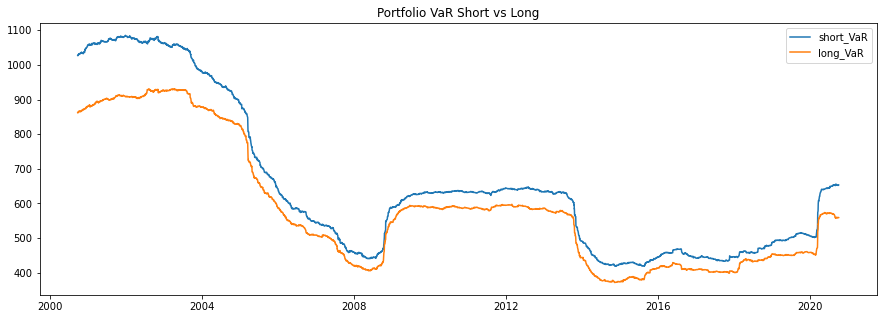

In [15]:
#portfolio
VaR_P_short = all_in_one(portfolio, 5)[2][0:252*20][::-1]
VaR_P_long = all_in_one(portfolio, 5)[4][0:252*20][::-1]
date = pd.to_datetime(pg['Dates'][0:252*20])
plt.figure(figsize = (15,5))
plt.plot(date[::-1],VaR_P_short, label = 'short_VaR')
plt.plot(date[::-1],VaR_P_long, label = 'long_VaR')
plt.legend()
plt.title('Portfolio VaR Short vs Long')

### seems like for both individual stock and the portfolio, the short VaR is greater than long VaR. Short position is more risky probably because the mu for log returns is mostly positive which means the stock is growing overall, Hence the short position is more risky

In [7]:
### Monte Carlo VaR stock gbm

def corr(data1,data2, window):
    data1 = Log_Return(data1)
    data2 = Log_Return(data2)
    
    corr = []
    
    

    for i in range(0,len(data1)-1):
        
        aa = data1['log_return'][i:i+252*window]
        bb = data2['log_return'][i:i+252*window]
        cov = np.cov(aa,bb)[0][1]
        corr.append(cov/(1/252*pg['sigma'][i]*wmt['sigma'][i]))
    
    return corr

In [22]:
corre= corr(pg,wmt,5)
c = np.multiply(corre,5/252)
VaR_s = []
ES_s = []
for i in range(0, len(portfolio)-1):
    ##cov matrix
    cov_matrix = [[5/252, c[i]],[c[i],5/252]]
    ## generate w1 w2
    x, y = np.random.multivariate_normal([0,0], cov_matrix, 50000).T
    
    ## stock gbm
    
    pg_v = pg['PX_LAST'][i]*np.exp((pg['mu'][i] - pg['sigma'][i]**2/2)*5/252 + pg['sigma'][i]*x ) 
    wmt_v = wmt['PX_LAST'][i]*np.exp((wmt['mu'][i] - wmt['sigma'][i]**2/2)*5/252 + wmt['sigma'][i]*y) 
    ## portfolio
    vt = 97*pg_v+ 108*wmt_v 
    shares = 10000/portfolio['PX_LAST'][i]
    
    portfolio_0 = 10000
    portfolio_value = 10000 + shares*portfolio['PX_LAST'][i] - shares*vt
    portfolio_loss = portfolio_0 - portfolio_value
    ## loss
    loss = 10000 - portfolio_value
    loss.sort()
    print(i)
    VaR_s.append(loss[49500])
    ES_s.append(np.mean(loss[48750:]))
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<ipython-input-22-466d32785da9>:9: RuntimeWarning: covariance is not positive-semidefinite.
  x, y = np.random.multivariate_normal([0,0], cov_matrix, 50000).T


Text(0.5, 1.0, 'Portfolio VaR Short vs Long')

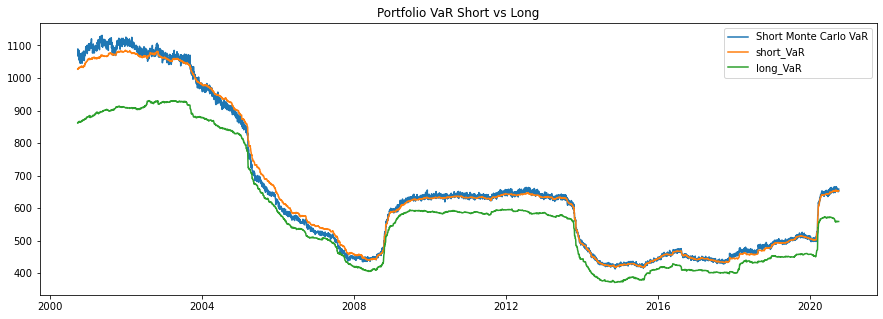

In [23]:
date = pd.to_datetime(pg['Dates'][0:252*20])
plt.figure(figsize = (15,5))
plt.plot(date[::-1],VaR_s[0:252*20][::-1], label ='Short Monte Carlo VaR')
plt.plot(date[::-1],all_in_one(portfolio, 5)[2][0:252*20][::-1], label = 'short_VaR')
plt.plot(date[::-1],all_in_one(portfolio, 5)[4][0:252*20][::-1], label = 'long_VaR')
plt.legend()
plt.title('Portfolio VaR Short vs Long')

### the short monte carlo VaR is close to the short parametric VaR but greater than long VaR and again it shows that short positions are more risky since the mu is mostly positive

# Q5

In [27]:
#short version Expected Shortfall  for portfolio GBM
def sigma_mu(data):
    sigma = []
    mu = []
    short_VaR = []
    long_VaR = []
    ES = []
    v0 = 10000
    for i in range(0,len(data)):
        sigma.append(data['sd'][i]*(252**0.5))
    for i in range(0,len(data)):
        mu.append(data['ma'][i]*252 + (sigma[i]**2)/2)
    for i in range(0, len(data)):
        
        
        shares = 10000/data['PX_LAST'][i]
        position_0 = 10000
        stock_value_0 = shares*data['PX_LAST'][i]
        stock_value_t = shares*data['PX_LAST'][i]*np.exp(sigma[i]* ((5/252)**0.5) * norm.ppf(0.99) + (mu[i] - sigma[i]**2/2)*(5/252))
        position_t = position_0 + stock_value_0 - stock_value_t
        short_VaR.append(position_0 - position_t )
        
        
        long_VaR.append( 10000 - shares*data['PX_LAST'][i]*np.exp(sigma[i]* ((5/252)**0.5) * norm.ppf(1-0.99) + (mu[i] - sigma[i]**2/2)*(5/252))  )
        
        
        
        ## expected shortfall
        
        #es_1 = norm.cdf(norm.ppf(0.975) - (5/252)**0.5*sigma[i])-1
        #es_2 = np.exp(mu[i] *(5/252))/(1-0.975)
        #ES.append( -es_2*es_1 -10000)
        
        #ES.append(10000*(1-np.exp(mu[i]*(5/252))/(1-0.975) * norm.cdf(norm.ppf(1-0.975) - (5/252)**(0.5)*sigma[i])))
        #ES.append(10000*(np.exp(mu[i]*(5/252))  * (1- norm.cdf(norm.ppf(0.975) - sigma[i])*5/252)/(1-0.975)-1))        
        
                   # S0 * (1 - np.exp(mu_years *T)/(1-0.975) * ss.norm.cdf(ss.norm.ppf(1-0.975) - T**(0.5)*vol_years))
        
        #es1 = norm.cdf(norm.ppf(1-0.975) - (5/252)**(0.5)*sigma[i])-1)
        #ES.append(-10000 + 10000*(norm.cdf(norm.ppf(1-0.975) - (5/252)**(0.5)*sigma[i])-1)*np.exp(mu[i]*(5/252))/(1-0.975)))
        
        
        ##expected shorfall for short portfolio
        
        es1 = np.exp(mu[i]*5/252)/(1-0.975)
        es2 = norm.cdf(  - norm.ppf(0.975) + sigma[i]*(5/252)**0.5)
        ES.append(-10000 + es1*es2*10000)
        
    data['sigma'] = sigma
    data['mu'] = mu
    data['short_VaR'] = short_VaR
    data['long_VaR'] = long_VaR
    #data['short_ES'] = ES
    return sigma, mu, short_VaR, ES, long_VaR


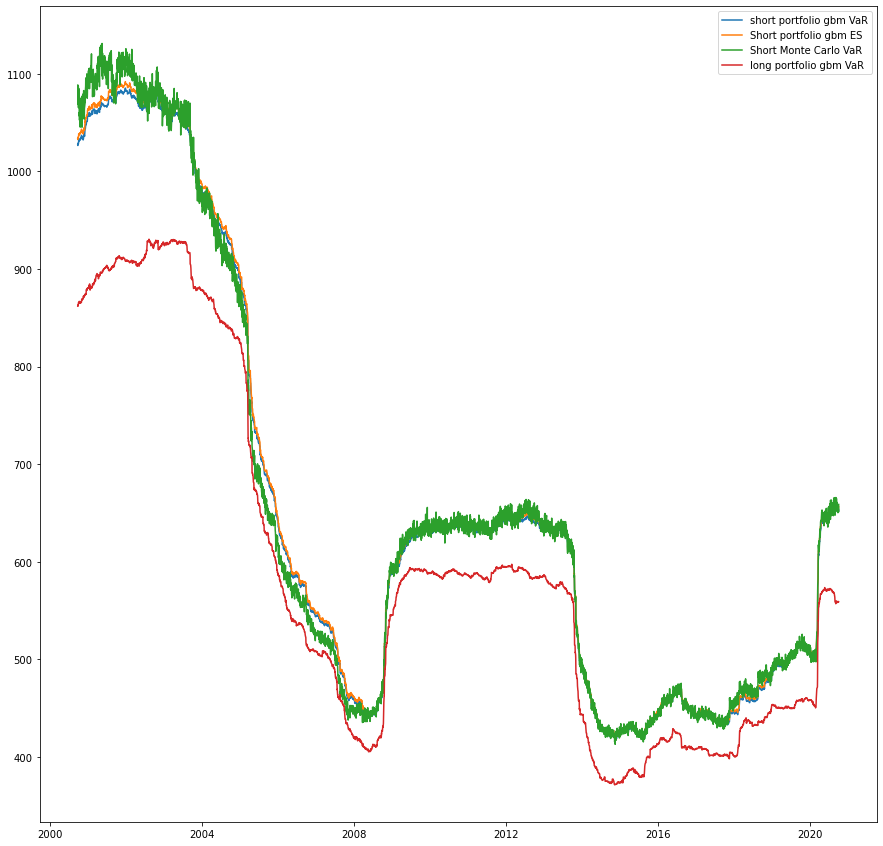

In [24]:
plt.figure(figsize = (15,15))
plt.plot(date[::-1],all_in_one(portfolio, 5)[2][0:252*20][::-1], label = 'short portfolio gbm VaR')
plt.plot(date[::-1],all_in_one(portfolio, 5)[3][0:252*20][::-1], label = 'Short portfolio gbm ES')
plt.plot(date[::-1],VaR_s[0:252*20][::-1], label ='Short Monte Carlo VaR')
plt.plot(date[::-1],VaR_P_long, label = 'long portfolio gbm VaR')
plt.legend()

## Short ES is close to short VaR and short Monte Carlo VaR and more risky than long positions

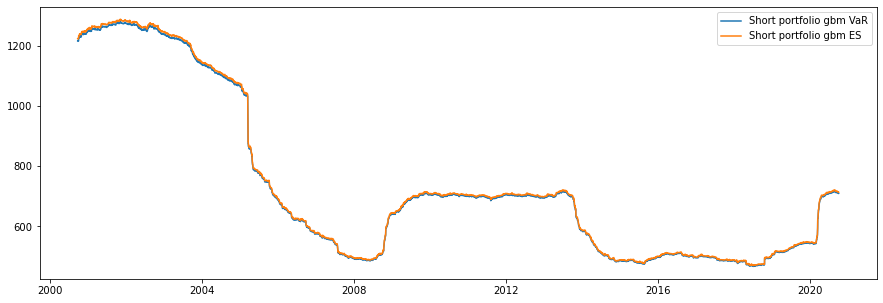

In [28]:
plt.figure(figsize = (15,5))
plt.plot(date[::-1],all_in_one(pg, 5)[2][0:252*20][::-1], label = 'Short portfolio gbm VaR')
plt.plot(date[::-1],all_in_one(pg, 5)[3][0:252*20][::-1], label = 'Short portfolio gbm ES')
plt.legend()

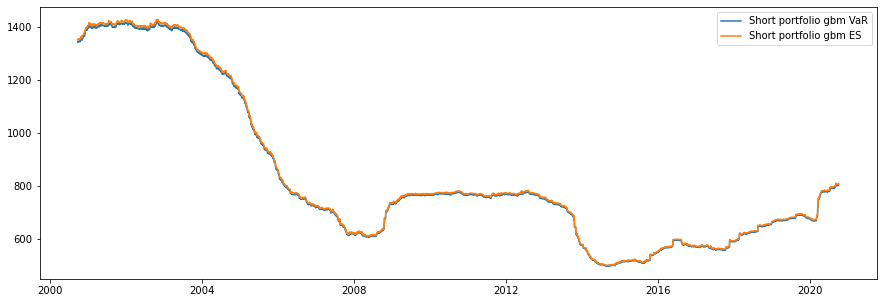

In [19]:
plt.figure(figsize = (15,5))
plt.plot(date[::-1],all_in_one(wmt, 5)[2][0:252*20][::-1], label = 'Short portfolio gbm VaR')
plt.plot(date[::-1],all_in_one(wmt, 5)[3][0:252*20][::-1], label = 'Short portfolio gbm ES')
plt.legend()

### For portfolio, PG and WMT, it seems like short VaR and ES for correlated gbm stocks portfolio are still extremely close. and they are both more risky than long positions